# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2023

## Project 3 - Triangular mesh generator

Due Friday, March 24

First we include some libraries and define utility functions from the lecture notes:

In [1]:
using PyPlot, LinearAlgebra, PyCall

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

function delaunay(p)
    # Delaunay triangulation `t` of array of nodes `p`
    tri = pyimport("matplotlib.tri")
    t = tri[:Triangulation](first.(p), last.(p))
    t = Int64.(t[:triangles] .+ 1)
    t = [ t[i,:] for i = 1:size(t,1) ]
end

delaunay (generic function with 1 method)

### Description

In this project you will write an unstructured triangular mesh generator based on the Delaunay refinement algorithm. The steps will be described in detail, and for testing we will use the following simple polygon:

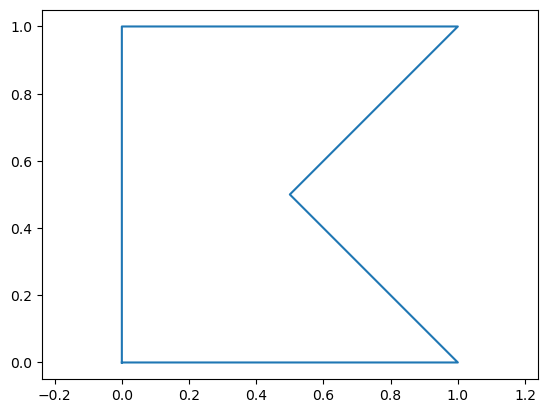

In [2]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

### Problem 1 - Point in polygon

Write a function `inpolygon(p, pv)` which determines if a point `p` is inside the closed polygon `pv`. For example, in the test polygon above, the point $(0.6,0.3)$ is inside but $(0.8,0.3)$ is outside. For the algorithm, use the "Crossing number method" as described here: <https://observablehq.com/@tmcw/understanding-point-in-polygon>.

In [3]:
function inpolygon(p, pv)
    y = p[2]
    inside = false
    for i = 1:length(pv) - 1
        p1 = pv[i]
        p2 = pv[i + 1]
        if (p1[2] < y) != (p2[2] < y)
            if p[1] < (p2[1] - p1[1]) * (y - p1[2]) / (p2[2] - p1[2]) + p1[1]
                inside = !inside
            end
        end
    end
    inside
end
inpolygon((0.6, 0.3), pv), inpolygon((0.8,0.3), pv)

(true, false)

### Problem 2 - Triangle properties

Next we need functions for computing some basic quantities from triangles. Here, a triangle `tri` is represented as an array of 3 points, e.g.

In [4]:
tri = [[1,0.5], [2,1], [0,3]]

3-element Vector{Vector{Float64}}:
 [1.0, 0.5]
 [2.0, 1.0]
 [0.0, 3.0]

### Problem 2(a) - Triangle area

Write a function `tri_area(tri)` which returns the area of `tri`.

In [5]:
function tri_area(tri)
    a = tri[1] - tri[2]
    b = tri[3] - tri[2]
    a_norm = norm(a)
    b_norm = norm(b)
    cosθ = dot(a, b) / (a_norm * b_norm)
    base = a_norm * cosθ
    if cosθ > 1
        cosθ = 1
    elseif cosθ < -1
        cosθ = -1
    end
    height = base * tan(acos(cosθ))
    area = abs(b_norm * height / 2)
end
tri_area(tri)

1.5000000000000002

### Problem 2(b) - Triangle centroid

Write a function `tri_centroid(tri)` which returns the centroid of `tri` (<https://en.wikipedia.org/wiki/Centroid#Of_a_triangle>).

In [6]:
function tri_centroid(tri)
    c = tri[2] + tri[3]
    centroid = 2(c / 2 - tri[1])/3 + tri[1]
end  
tri_centroid(tri)

2-element Vector{Float64}:
 1.0
 1.5

### Problem 2(c) - Triangle circumcenter

Write a function `tri_circumcenter(tri)` which returns the circumcenter of `tri` (<https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates_2>).

In [7]:
function tri_circumcenter(tri)
    a = tri[1] - tri[2]
    b = tri[2] - tri[3]
    p1 = a/2 + tri[2]
    p2 = b/2 + tri[3]
    aperp = [-a[2], a[1]]
    bperp = [-b[2], b[1]]
    A = [bperp aperp]
    y = p1 - p2
    x = A \ y
    center = x[1] * bperp + p2
end
tri_circumcenter([[1,0], [0,1], [0,0]])

2-element Vector{Float64}:
 0.5
 0.5

### Problem 3 - Mesh generator

Write a function with the syntax `p,t = pmesh(pv, hmax)` which generates a mesh `p,t` of the polygon `pv`, with triangle side lengths approximately `hmax`. Follow the algorithm as described below.

(a) The input `pv` is an array of points which defines the polygon. Note that the last point is equal to the first (a closed polygon).

(b) First, create node points `p` along each polygon segment, separated by a distance approximately equal to `hmax`. Make sure not to duplicate any nodes.

(c) Triangulate the domain using the `delaunay` function.

(d) Remove the triangles outside the polygon, by computing all the triangle centroids (using `tri_centroid`) and determining if they are inside (using `inpolygon`).

(e) Find the triangle with largest area $A$ (using `tri_area`). If $A>h_\mathrm{max}^2/2$, add the circumcenter of the triangle to the list of node points `p`.

(f) Repeat steps (c)-(d), that is, re-triangulate and remove outside triangles.

(g) Repeat steps (e)-(f) until no triangle area $A>h_\mathrm{max}^2/2$.

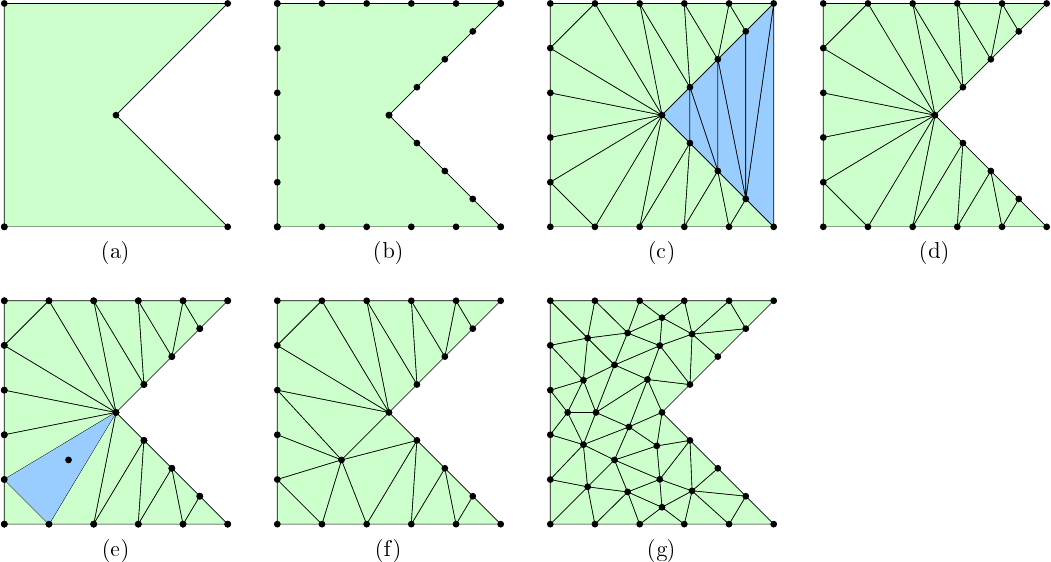

In [8]:
function pmesh(pv, hmax)
    p = []
    for i = 1:length(pv) - 1
        edge = pv[i + 1] - pv[i]
        length = norm(edge)
        spaces = ceil(length / hmax)
        push!(p, pv[i])
        for j = 1:spaces - 1
            push!(p, j/spaces*edge + pv[i])
        end
    end

    while true
        t1 = delaunay(p)
        t2 = []
        maxarea = -1
        maxindex = 0
        for i = 1:length(t1)  
            tri_points = p[[t1[i][1], t1[i][2], t1[i][3]]]
            if inpolygon(tri_centroid(tri_points), pv)
                push!(t2, t1[i])
            end
        end
        
        for i = 1:length(t2)
            tri_points = p[[t2[i][1], t2[i][2], t2[i][3]]]
            current_area = tri_area(tri_points)
            if  current_area > maxarea
                maxarea = current_area
                maxindex = i
            end
        end
        
        if maxarea ≤ hmax^2/2
            return p, t2
            break
        else
            push!(p, tri_circumcenter(p[[t2[maxindex][1], t2[maxindex][2], t2[maxindex][3]]]))
        end
    end
end

pmesh (generic function with 1 method)

### Test cases

Run the cases below to test your mesh generator.

In [9]:
tri_area([[0.625, 0.625], [0.4, 1.0], [0.5, 0.5]])

0.03749999999999997

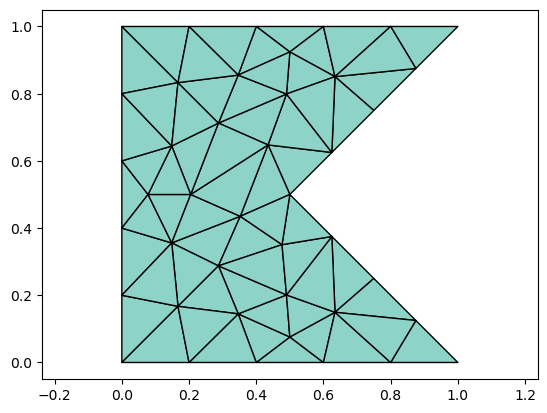

In [10]:
# The polygon in the examples
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
p,t = pmesh(pv, 0.2)
tplot(p,t)

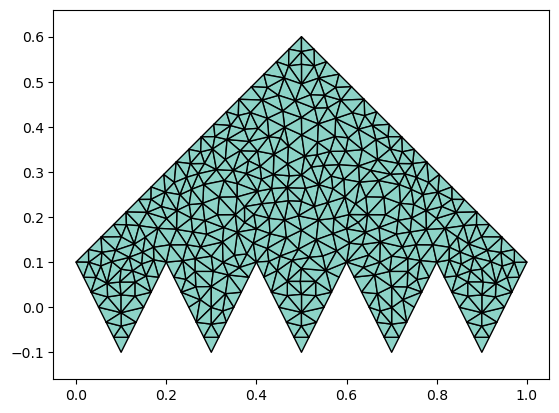

In [11]:
# A more complex shape
pv = [[i/10,0.1*(-1)^i] for i = 0:10]
append!(pv, [[.5,.6], [0,.1]])
p,t = pmesh(pv, 0.04)
tplot(p,t)